#  Chalet heat transfer analysis (EVA DMBEM Project)


## Physical analysis and mathematical model

### Location: Zermatt, CH

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import math
from dm4bem import read_epw, sol_rad_tilt_surf
import tuto

# importing data extracted from weather data

rad_E = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\depalfra_project\tot_rad_E.csv')

rad_ER = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\depalfra_project\tot_rad_ER.csv')

rad_G = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\depalfra_project\tot_rad_G.csv')

rad_N = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\depalfra_project\tot_rad_N.csv')

rad_S = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\depalfra_project\tot_rad_S.csv')

rad_W = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\depalfra_project\tot_rad_W.csv')

rad_WR = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\depalfra_project\tot_rad_WR.csv')

T_out = pd.read_csv(r'C:\Users\Mario\Desktop\ZHAW_modules\HS2021\EVA_DMBEM\depalfra_project\T_out.csv')

# Physical properties
# ===================
wall = {'Conductivity': [0.18,0.040,0.12,0.08,1.4],
        'Density': [800, 16, 600,2000,2500],
        'Specific heat': [2385, 1210, 2385,920,750],
        'Width': [0.1, 0.2, 0.1, 0.2,0.004],
        'Slices': [ 2, 2, 2, 2, 1]}

wall = pd.DataFrame(wall, index=['Beech', 'Insulation', 'Oak','Brick','Glass'])

air = {'Density': 1.007,
       'Specific heat': 1150}

# altitude: 1608 m

Let’s consider the heat transfer through a wall which separates the outside air, at temperature $T_o$ from the inside air. Heat $Q_h$ is added to the inside air by a fan-coil (see figure). Moreover, in the pictures below the thermal circuit of the single walls, the assembled circuit and an iconic representation of the chalet are given.



![cube](chalet_image.PNG)

![cube](tc_chalet.JPG)

The thermal properties of the wall and of the air are:

In [2]:
wall

,Conductivity,Density,Specific heat,Width,Slices
Beech,0.18,800,2385,0.100,2
Insulation,0.04,16,1210,0.200,2
Oak,0.12,600,2385,0.100,2
Brick,0.08,2000,920,0.200,2
Glass,1.40,2500,750,0.004,1


In [3]:
air

{'Density': 1.007, 'Specific heat': 1150}

We'll consider the convection coefficients for indoor and outdoor:

In [4]:
# convection coefficients, W/m² K

# estimation of the outer convection coefficient by using the following empirical formula:

nu = 12.94e-6
Too = 268.15
beta = 1/Too
g = 9.81
DT = 10
L = 10
Gr = (g*beta*DT*(L**3))/(nu**2)
k_air = 0.046
mu = nu*1.007
Pr = (mu*1150)/k_air
Ra = Gr*Pr
Nu = 0.1*(Ra**(1/3))
h_out = Nu*k_air/L 

h = pd.DataFrame([{'in': 4., 'out': h_out}])

The dimensions of the walls are 10 x 3 m² (vertical walls) and the volume of the indoor air is 10 x 10 x 3 m³.

In [5]:
# Walls

S_wall_big = 10*2.5 + 25
S_wall = 10*2.5
S_roof = S_wall + 25

V_air = 9.6 * 9.6 * 3 + ((10/math.sqrt(2))*9.6*0.5)  # m³
m_dot = 0.3*V_air*air['Density']/3600

## Thermal network model


The wall consists of three layers: exterior wood (beech), insulation and interior wood (oak). Moreover, an additional thermal circuit is derived for the roof. Every layer is discretized in 2 slices each. By adding together the resistances which are in series, the following thermal nework is obtained:

> Thermal nework model of a simple wall obtained by considering the equivalent resistances of the resistanaces in series. The model contains capacities in the nodes.

The circuit elements of the thermal network are the resistances and the capacities. Their values are found by using the thermo-physical properties of the materials.

### Resistances and capacities in the thermal network

The thermal resistances for conduction are of the form:
$$R_{cd} = \frac{w}{\lambda S}$$
where:

- $w$ is the width of the material, m;
- $\lambda$ - thermal conductvity, W/m K;
- $S$ - surface area of the wall, m²

In [6]:
# conduction (big walls)
R_cd = wall['Width'] / (wall['Conductivity'] * S_wall_big)

The thermals resistance for convection are of the form:
$$R_{cv} = \frac{1}{h S}$$
where:
- $h$ is the convection coefficient, W/m² K;
- $S$ - surface area of the wall, m².

In [7]:
# convection (big wall)
R_cv = 1 / (h * S_wall_big)

The thermal capacities of the walls are of the form:
$$C_{wall}= \rho_{wall} c_{p, wall} w_{wall} S_{wall}$$

In [8]:
C_wall_big = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall_big
C_wall = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall
C_wall_roof = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_roof

The thermal capacity of the air is:
$$C_{air} = \rho_{air} c_{air} V_{air}$$

Kp is the proportional coefficient for the control system

In [9]:
Gv = air['Specific heat']*m_dot
Kp = 1000
Qa = 2000
Ca = air['Density'] * air['Specific heat'] * V_air

## Differential algebraic equations (DAE)

The number of temperature nodes and of flow branches of the thermal network depend on the number of slices obtained by the discretization of the wall:

In [10]:
# number of temperature nodes and flow branches
no_t = no_q = 7

### Conductance matrix **G**
The resistances are grouped in the conductance matrix, which is diagonal:
$$G = \begin{bmatrix}
R_0^{-1} &  &  & \\ 
 & R_1^{-1} &  & \\ 
 &  & ... & \\ 
 &  &  & R_{nq}^{-1}
\end{bmatrix}$$

where:
- $nq$ is the number of flow branches, $nq = 7$;
- $R_0 = R_{cv,out} + R_{cd,beech} / 4$ ; 
- $R_1 = R_{cd,beech} / 2$; 
- $R_2 = R_{cd,beech} / 4 + R_{cd,insulation} / 4$;
- $R_3 = R_{cd,insulation} / 2$; 
- $R_4 = R_{cd,insulation} / 4 + R_{cd,oak} / 4$;
- $R_5 = R_{cd,oak} / 2$;
- $R_6 = R_{cd,oak} / 4$ ; 

*Note*: each branch of the network needs to have a resistance (or a conductance).

In [11]:
# Conductance matrix (big wall)
R = np.zeros([no_q])
R[0] = R_cv['out'] + R_cd['Beech'] / 4
R[1] = R_cd['Beech'] / 2
R[2] = R_cd['Beech'] / 4 + R_cd['Insulation'] / 4
R[3] = R_cd['Insulation'] / 2
R[4] = R_cd['Insulation'] / 4 + R_cd['Oak']/4
R[5] = R_cd['Oak'] / 2
R[6] = R_cd['Oak'] / 4 
G_big = np.diag(np.reciprocal(R))

### Capacity matrix **C**
The capacities are grouped in the capacity matrix, which is diagonal:
$$C = \begin{bmatrix}
C_0 &  &  & \\ 
 & C_1 &  & \\ 
 &  & ... & \\ 
 &  &  & C_{nt}
\end{bmatrix}$$

where:
- $nt$ is the number of temperature nodes, $nt = 7$;

*Note*: not every temperature node needs to have a capacity. The capacity of a surface is zero, since its volume and, consequently, its mass are zero.

In [12]:
C_big = np.zeros(no_t)
C_big = np.diag([0,C_wall['Beech'],0,C_wall['Insulation'],0,C_wall['Oak'],0])


### Arc-node incidence matrix $A$
The rows in the incidence matrix $A$ corespond to the branches containing the heat flow rates $q_k$ across the resistances $R_k$ and the columns correspond to the temperature nodes $\theta_l$. In the row corresponding to the branch $R_k$ in the position of the node $\theta_l$ there is -1 if the flow $q_k$ leaves the node, +1 if the flow $q_k$ enters into the node $\theta_k$ and 0 if the resistance $R_k$ is not connected to the temperature node $\theta_k$ [Ghiaus, 2013]:

$$a_{kl} = \begin{cases}
\phantom{-} 0 & \text{if flow branch } q_k \text{ is not connected to the temperature node }  \theta_l \\ 
+1 & \text{if flow branch } q_k \text{ enters into the temperature node }  \theta_l\\ 
-1 & \text{if flow branch } q_k \text{ gets out of the temperature node }  \theta_l 
\end{cases}$$

The matrix -$A$ is a difference operator for the temperatures: $e = -A \theta$ is the vector of differences between temperatures connected by resistances [Ghiaus, 2013].

In [13]:
A = np.eye(no_q, no_t + 1)
A = -np.diff(A, n=1, axis=1)
print(A)

[[ 1. -0. -0. -0. -0. -0. -0.]
 [-1.  1. -0. -0. -0. -0. -0.]
 [-0. -1.  1. -0. -0. -0. -0.]
 [-0. -0. -1.  1. -0. -0. -0.]
 [-0. -0. -0. -1.  1. -0. -0.]
 [-0. -0. -0. -0. -1.  1. -0.]
 [-0. -0. -0. -0. -0. -1.  1.]]


### Vectors of temperature sources **b** and flows **f**
First, we will set all the temperature sources **b** and flow sources **f** to zero, then we define unitary values for **b** and **f**:

In [14]:
b = np.zeros(no_q)
f = np.zeros(no_t)

f[0] = f[-1] = 1
b[0] = 1
y = np.zeros(no_t)

## Small wall

In [15]:
# conduction
R_cd = wall['Width'] / (wall['Conductivity'] * S_wall)

# convection
R_cv = 1 / (h * S_wall)
R_in_small = R_cv['in']

# Conductance matrix
R = np.zeros([no_q])
R[0] = R_cv['out'] + R_cd['Beech'] / 4
R[1] = R_cd['Beech'] / 2
R[2] = R_cd['Beech'] / 4 + R_cd['Insulation'] / 4
R[3] = R_cd['Insulation'] / 2
R[4] = R_cd['Insulation'] / 4 + R_cd['Oak']/4
R[5] = R_cd['Oak'] / 2
R[6] = R_cd['Oak'] / 4
G_small = np.diag(np.reciprocal(R))

# Capacity matrix
C_small = np.zeros(no_t)
C_small = np.diag([0,C_wall['Beech'],0,C_wall['Insulation'],0,C_wall['Oak'],0])

## Roof

In [16]:
# conduction
R_cd = wall['Width'] / (wall['Conductivity'] * S_roof)

# convection
R_cv = 1 / (h * S_roof)
R_in_roof = R_cv['in']
                        
# Conductance matrix
R = np.zeros([no_q])
R[0] = R_cv['out'] + R_cd['Brick'] / 4
R[1] = R_cd['Brick'] / 2
R[2] = R_cd['Brick'] / 4 + R_cd['Insulation'] / 4
R[3] = R_cd['Insulation'] / 2
R[4] = R_cd['Insulation'] / 4 + R_cd['Oak']/4
R[5] = R_cd['Oak'] / 2
R[6] = R_cd['Oak'] / 4
G_roof = np.diag(np.reciprocal(R) )

C_roof = np.zeros(no_t)                      
C_roof = np.diag([0,C_wall_roof['Brick'],0,C_wall_roof['Insulation'],0,C_wall_roof['Oak'],0])

## Glass window

In [17]:
no_t = no_q = 2

# conduction
R_cd = wall['Width'] / (wall['Conductivity'] * S_wall_big)

# convection
R_cv = 1/(h * S_wall_big)
R_in_glass = R_cv['in']

R = np.zeros([no_q])
R[0] = R_cv['out'] + R_cd['Glass'] / 2
R[1] = R_cd['Glass'] / 2
G_glass = np.diag(np.reciprocal(R))                      
                        
C_glass = np.zeros([no_t,no_q])

A_glass = np.eye(no_q, no_t + 1)
A_glass = -np.diff(A_glass, n=1, axis=1)

b_glass = np.zeros(no_q)
f_glass = np.zeros(no_t)
y_glass = np.zeros(no_t)

b_glass[0] = 1
y_glass[-1] = 1

## Convection circuit

In [18]:
no_t = 7
no_q = 6

R_cv = 1 / (h * S_wall_big)
R_in_big = R_cv['in']

R = np.zeros([no_q])
R[0] = R_in_big
R[1] = R_in_small
R[2] = R_in_glass
R[3] = R_in_small
R[4] = R_in_roof
R[5] = R_in_roof
G_cv = np.diag(np.reciprocal(R))

A_cv = np.zeros([no_q,no_t])
for k in range(no_q):
    for i in range(no_t + 1):
        if k == i:
            A_cv[k,i] = -1;
        if i == 6:
            A_cv[k,i] = 1

C_cv = np.zeros(no_t)
C_cv[-1] = Ca/2 
C_cv = np.diag(C_cv)

b_cv = np.zeros(no_q)
f_cv = np.zeros(no_t)
y_cv = np.zeros(no_t)
y_cv[-1] = 1;


## Ventilation and control system circuit

In [19]:
A_vc = np.array([[1],
                  [1]])
G_vc = np.diag(np.array([Gv, Kp]))
b_vc = np.array([1, 1])
C_vc = np.array([Ca/2])
f_vc = 1
y_vc = 1

## Assembling circuits

In [20]:
TC_North_wall = {'A': A, 'G': G_big, 'b': b, 'C': C_big, 'f': f, 'y': y}

TC_East_wall = {'A': A, 'G': G_small, 'b': b, 'C': C_small, 'f': f, 'y': y}

TC_West_wall = {'A': A, 'G': G_small, 'b': b, 'C': C_small, 'f': f, 'y': y}

TC_South_wall = {'A': A_glass, 'G': G_glass, 'b': b_glass, 'C': C_glass, 'f': f_glass, 'y': y_glass}

TC_East_roof = {'A': A, 'G': G_roof, 'b': b, 'C': C_roof, 'f': f, 'y': y}

TC_West_roof = {'A': A, 'G': G_roof, 'b': b, 'C': C_roof, 'f': f, 'y': y}

TC_CV = {'A': A_cv, 'G': G_cv, 'b': b_cv, 'C': C_cv, 'f': f_cv, 'y': y_cv}

TC_VC = {'A': A_vc, 'G': G_vc, 'b': b_vc, 'C': C_vc, 'f': f_vc, 'y': y_vc}


## Total circuit and assembling matrix 

The picture below shows the total assembled thermal circuit:

![cube](indoor_node_image.PNG)


In [21]:
TCd = {'0': TC_North_wall,
       '1': TC_East_wall,
       '2': TC_South_wall,
       '3': TC_West_wall,
       '4': TC_East_roof,
       '5': TC_West_roof,
       '6': TC_CV,
       '7': TC_VC}

# Assembling matrix

AssX = np.array([[0, 6, 6, 0],
                   [1, 6, 6, 1],
                   [2, 1, 6, 2],
                   [3, 6, 6, 3],
                   [4, 6, 6, 4],
                   [5, 6, 6, 5],
                   [6, 6, 7, 0]])


TCa = dm4bem.TCAss(TCd, AssX)


Their values will be changed depending on the conditions.

The system of Algebraic-Differential Equations is:

$$C\dot{\theta} = -A^T G A \theta + A^T G b + f$$

## Steady state solution

The solution in steady-state is:

$$\theta = (A^T G A)^{-1}(A^T G b + f)$$

$$q = G (-A \theta + b)$$ 

We will consider one steady state: 
 The outdoor temperature is 1 °C, $b_0 = 1$.

In [22]:
b[0] = 1
T_ss = np.linalg.inv(TCa['A'].T@TCa['G']@TCa['A'])@(TCa['A'].T@TCa['G']@TCa['b'])

print('When To = 1°C, the temperatures in steady-state are:', T_ss)
print(f'The indoor temperature is: {T_ss[-1]:.3f} °C')

When To = 1°C, the temperatures in steady-state are: [1.0 1.0000000000000002 1.0000000000000004 1.0000000000000013
 1.0000000000000018 1.0000000000000018 1.000000000000002 1.0 1.0
 1.0000000000000004 1.0000000000000013 1.0000000000000018
 1.0000000000000018 1.000000000000002 1.000000000000016 1.0000000000000158
 1.0 1.0 1.0000000000000004 1.0000000000000013 1.0000000000000018
 1.0000000000000018 1.000000000000002 1.0000000000000002
 1.0000000000000007 1.0000000000000013 1.0000000000000018
 1.0000000000000022 1.0000000000000024 1.0000000000000022
 1.0000000000000002 1.0000000000000007 1.0000000000000013
 1.0000000000000018 1.0000000000000022 1.0000000000000024
 1.0000000000000022 1.0000000000000024]
The indoor temperature is: 1.000 °C


## State-space model
If the matrix $C$ is invertible (or non-singular), then the Differential-algebraic system of equations

$$C\dot{\theta} = -A^T G A \theta + A^T G b + f$$

can be put in the state-space representation

$$\left\{\begin{array}{rr}
\dot{\theta}=A_s \theta + B_s u\\ 
y = C_s \theta + D_s u
\end{array}\right.$$

where:
- $u = \begin{bmatrix} b \\ f\end{bmatrix}$ is the vector of inputs (temperature sources $b$ and flow sources $f$);
- $A_s = -C^{-1} A^T G A$ is the state matrix, $\dim A = n_\theta \times n_\theta$;
- $B_s = C^{-1}\begin{bmatrix}
A^T G & I
\end{bmatrix}$ is the input matrix, $\dim B = n_\theta \times n_u$;
- $C_s = \begin{bmatrix} 0 & 0 & ... &1 \end{bmatrix}$ is the output matrix, $\dim C = 1 \times n_\theta$;
- $D_s = \begin{bmatrix} 0 & 0 & ... &0 \end{bmatrix}$ is the feedthrough (or feedforward matrix, $\dim D = 1 \times n_u$.

The first equation, $ \dot{\theta}=A_s \theta + B_s u $, is called *state* or *system* equation and the second equation, $ y = C_s \theta + D_s u $, is calld *observation* equation,

The input matrix is
$B_s = C^{-1}\begin{bmatrix}
A^T G & I
\end{bmatrix}$

In [23]:
## Thermal circuit -> state-space

[As, Bs, Cs, Ds] = dm4bem.tc2ss(
    TCa['A'], TCa['G'], TCa['b'], TCa['C'], TCa['f'], TCa['y'])

The input vector if formed by stacking the vector of temperature sources $b$ and the vector of flow sources $f$:
$$u = \begin{bmatrix} b \\ f\end{bmatrix}$$

However, many sources in the model are zero. For our example, there are only two sources: $T_o$ and $Q_h$. Therefore,
$$b = \begin{bmatrix}
T_o\\ 
0\\ 
...\\ 
0
\end{bmatrix}$$
and
$$f = \begin{bmatrix}
0\\ 
0\\ 
...\\ 
Q_h
\end{bmatrix}$$

Since the sources which are always zero have no influence on the outputs, they cen be neglected. Only the columns that correspond to existing sources, i.e., the 1st and the last, are kept in matix $B$: 

## Eigenvalues, numerical stability and time-step

The stability condition for explicit Euler method requires that all eigenvalues $\lambda _i \in \mathbb{Z}$ of the state matrix $A$ satisfy the condition
$$ \left | 1 + \lambda _i \Delta t \right | \leq 1, \forall i $$

If the all eigenvalues of state matrix $A$ are real, as is the case for thermal networks, then the above condition becomes:
$$ -2 \leq \lambda _i\Delta t\leq 0, \forall i $$.

Since the eigenvalues $\lambda_i$ are related to time constants $T_i$,
$$ \lambda _i = - \frac{1}{T_i} $$
it results that the condition for stability is 
$$ \Delta t \leq \min T_i/2 = -2 / \min \lambda_i $$

In [24]:
# Maximum time-step

dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 458.24 s


We choose a time step smaller than the maximum admited for stability.

In [25]:
dt = 50

## Time integration using explcit and implicit Euler methods
We will study the dynamics reponse of the of the model to: 
- a step variation of a source (outdoor temperature $T_o$ or indoor flow $Q_h$);
- variation of outdoor temperature given by weather data.


Since the data is given hourly, the number of days in the simulation will be:

In [26]:
days = T_out.shape[0] / 24

The number of steps and the time vector will be

In [27]:
# number of steps
n = int(np.ceil(3600 / dt * 24 * days))
no_q = As.shape[0]
no_t = As.shape[1]
no_Q = int(Bs.shape[0])
no_T = int(Bs.shape[1])

# time
t = np.arange(0, n * dt, dt)

### Step input: outdoor temperature $T_o$

Let's consider that the outdoor temperature $T_o$ has a step variation of 1°C (the indoor heat flow is zero, $Q_h = 0$:

In [28]:
u = np.block([[np.ones([8, n])],
              [np.zeros([11, n])]])

We initialize to zero the temperature vector for explicit and implicit Euler.

In [29]:
# initial values for temperatures obtained by explicit and implicit Euler
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])

The formula for Euler forward (or explicit) integration is
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$
and for Euler backward (or implicit) integration it is
$$\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta _k + \Delta t B u_k )$$

In [30]:
for k in range(t.shape[0] - 1):
    temp_exp[:, k + 1] = (np.eye(no_t) + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])


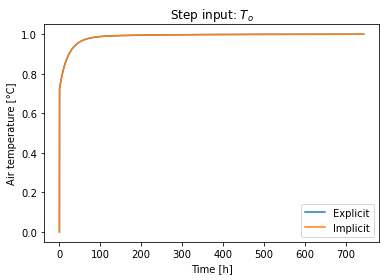

In [31]:
fig, ax = plt.subplots()
ax.plot(t / 3600, temp_exp[-1, :], t / 3600, temp_imp[-1, :])
ax.set(xlabel='Time [h]', ylabel='Air temperature [°C]', title='Step input: $T_o$')
ax.legend(['Explicit', 'Implicit'])

### Step input: indoor heat flow $Q_h$

Let's consider that the outdoor temperature $Q_h$ has a step variation of 1 W (the outdoor temperature is zero, $T_o = 0$:

In [32]:
u = np.block([[np.ones([8, n])],
              [np.zeros([11, n])]])

We initialize again to zero the temperature vector for explicit and implicit Euler.

In [33]:
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])

The formula for Euler forward (or explicit) integration is
$$ \theta_{k+1} = (I + \Delta t A) \theta _k + \Delta t B u_k $$
and for Euler backward (or implicit) integration it is
$$\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta _k + \Delta t B u_k )$$

In [34]:
for k in range(t.shape[0] - 1):
    temp_exp[:, k + 1] = (np.eye(no_t) + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

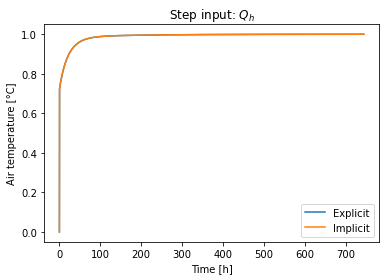

In [35]:
fig, ax = plt.subplots()
ax.plot(t / 3600, temp_exp[-1, :], t / 3600, temp_imp[-1, :])
ax.set(xlabel='Time [h]', ylabel='Air temperature [°C]', title='Step input: $Q_h$')
ax.legend(['Explicit', 'Implicit'])

### Simulation with outdoor temperature, $T_o$, from Zermatt weather data

Time vector (in seconds) for weather data:

In [36]:
# time for weather (in seconds)
tw = np.arange(0, 3600 * T_out.shape[0], 3600)
# change the timestep from 1h to dt
t = np.arange(0, 3600 * T_out.shape[0], dt)
# outdoor temperature at timestep dt
T0 = np.interp(t, tw, T_out['temp_air'])
n_T = T0.shape[0]
Tsp = 20*np.ones([1, n_T])
Tm = (T0*Gv + Tsp*Kp)/(Gv + Kp)
n_T = T0.shape[0]

radN = np.interp(t, tw, rad_N['0'])
radE = np.interp(t, tw, rad_E['0'])
radS = np.interp(t, tw, rad_S['0'])
radW = np.interp(t, tw, rad_W['0'])
radER = np.interp(t, tw, rad_ER['0'])
radWR = np.interp(t, tw, rad_WR['0'])

n_r = radS.shape[0]
rad_in = Qa*np.ones([1, n_r]) + 0.85*radS/6

Form the input vector $u$ from outdoor temperature and indoor heat flow $Q_h$, which is zero:

In [37]:
u = np.block([[T0],
              [T0],
              [T0],
              [T0],
              [T0],
              [T0],
              [T0],
             [Tsp],
             [radN],
             [0.85*radS/6],
             [radE],
             [0.85*radS/6],
             [radW],
             [0.85*radS/6],
             [radER],
             [0.85*radS/6],
             [radWR],
             [0.85*radS/6],
             [rad_in]])

Initialize the temperature vectors for explicit and implicit Euler and integrate.

In [38]:
temp_exp = np.zeros([no_t, n])
temp_imp = np.zeros([no_t, n])
temp_exp = np.zeros([no_t, t.shape[0]])
temp_imp = np.zeros([no_t, t.shape[0]])

for k in range(n - 1):
    temp_exp[:, k + 1] = (np.eye(no_t) + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(np.eye(no_t) - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

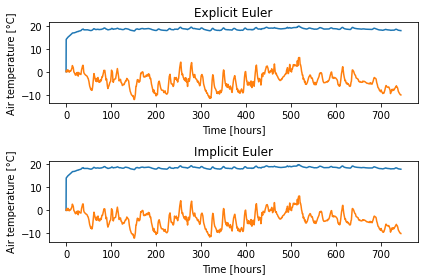

In [39]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(t / 3600, temp_exp[-1, :],
               t / 3600, T0)
axs[0].set_xlabel('Time [hours]')
axs[0].set_ylabel('Air temperature [°C]')
axs[0].set_title('Explicit Euler')

axs[1].plot(t / 3600, temp_imp[-1, :],
               t / 3600, T0)
axs[1].set_xlabel('Time [hours]')
axs[1].set_ylabel('Air temperature [°C]')
axs[1].set_title('Implicit Euler')

fig.tight_layout()

## Remarks

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then,the controller is inefffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and $C_g =$ `C['Glass']`are considered, then the time step is small;
    - if the capacities of the air and of the glas are zero, then the time step is large.

The controller models an HVAC system capable to heat (when $q_{HVAC} > 0$) and to cool $q_{HVAC} < 0$).

**References**

C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024
